# GPL Paper Section 4.1.2 Experiment: Quadratic Hamiltonian with L1 Prior

This code attempts to learn 2D prior $J(x) = \|x\|_1$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian
$H(p) = \frac{1}{2}\|p\|_2^2$ (Using the method of characterization).
The LPN learns the function $\psi(y) = J^*(y) - \frac{1}{2}\|y\|_2^2$.
Training data uses samples $\{y_j,\psi(y_j)\}$ where $\psi(y_j) = \frac{1}{2}\|y_j\|_2^2 - S(y_j,1)$, and,
$S(y_j,1) = \min_{x \in \mathbb{R}^d} \{\frac{1}{2}\|x-y_j\|_2^2 + \|x\|_1\}$ (Moreau envelope of $J(x)=\|x\|_1$ at $t=1$).

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_4_1_2_quadratic_16DD"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:
# Parameters
# --- Parameters for Sec 4.1.2 L1 Prior Experiment ---
dim_exp = 16  # Dimension (e.g., 2D, 4D, 8D as in the paper)
data_points_exp = 30000 # Example number of data points
iterations_exp_initial = 1 # Iterations for initial training phase
iterations_exp_long = 100000 # Iterations for longer training phase
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 50 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 50     # number of hidden units
layers = 4      # number of layers
#eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

# === Section 4.1.2===

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section 4.1.2: L1 Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)

def prox_l1_vec(y, t_lambda):
    """ Element-wise proximal operator of t_lambda*||x||_1 (soft-thresholding). """
    return np.sign(y) * np.maximum(np.abs(y) - t_lambda, 0)

def hjsol_true_quadratic_l1(y_points,n=1.0, t=1.0): # y_points is N x dim
    """
    Computes S(y, t=1) for J(x)=||x||_1.
    S(y, 1) = ||x||_1 + nt/2 }
    """
    t_moreau = 1.0
    prox_y = prox_l1_vec(y_points, t_moreau) # element-wise for N x dim
    s_values = np.sum(np.abs(prox_y), axis=1) +n * t/2 # L1 norm for each vector y_j 
    return s_values # N-dimensional array

def prior_true_quadratic_l1(y_points): # y_points is N x dim
    """ Computes the true prior J(y) = ||y||_1. """
    return np.sum(np.abs(y_points), axis=1) # N-dimensional array

def cvx_true_quadratic_l1(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = 0.5*||y||_2^2 - S(y, t=1) for J(x)=||x||_1.
    """
    s_y_1 = hjsol_true_quadratic_l1(y_points)
    psi_y = 0.5 * euclid_norm_sq(y_points) - s_y_1
    return psi_y # N-dimensional array

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est

def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_quadratic_l1(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_quadratic_l1(x1_0_points)
    x1_0_J_true = prior_true_quadratic_l1(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_quadratic_l1(x2_0_points)
        x2_0_J_true = prior_true_quadratic_l1(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=\\|x\\|_1$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_quadratic_l1(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, L1 Prior (Dim={dim}) ---")
    cross_sections_plots_quadratic_l1(model, a, spacing, INVERT_MODE, dim)



In [4]:

def exp_func(x, gamma):
    # Ensure x is a 1D tensor for vector_norm if it comes in as N x 1
    if x.ndim > 1 and x.shape[1] == 1:
        x = x.squeeze(1)
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim=-1)/ gamma) ** 2)) + 1.0

# --- Generate Training Data (using Moreau envelope target as per notebook) ---

In [5]:
# --- Generate Training Data ---
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))

cvx_samples_exp_np = cvx_true_quadratic_l1(y_j_exp_np)
cvx_samples_exp_np = cvx_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float()
cvx_samples_exp_tensor = torch.from_numpy(cvx_samples_exp_np).float()
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, cvx_samples_exp_tensor shape {cvx_samples_exp_tensor.shape}")
# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
cvx_samples_exp_tensor = cvx_samples_exp_tensor.to(device)

Generated training data: y_j_exp_tensor shape torch.Size([30000, 16]), cvx_samples_exp_tensor shape torch.Size([30000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

print("--- Training LPN for J(x)=||x||_1 (Quadratic H) ---")
lpn_model_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_quad_l2 = torch.optim.Adam(lpn_model_quad_l2.parameters(), lr=1e-4)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_quad_l2, optimizer_quad_l2, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=2,gamma_loss=None)

for g in optimizer_quad_l2.param_groups:
    g["lr"] = 1e-4 
for i in range(iterations_exp_long):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_quad_l2.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points_exp, lpn_model_quad_l2, optimizer_quad_l2, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=2,gamma_loss=None)

torch.save(lpn_model_quad_l2.state_dict(), os.path.join(MODEL_DIR, "QuadraticH_L1prior_l2.pth"))

--- Training LPN for J(x)=||x||_1 (Quadratic H) ---


iteration 0 loss 609.7056884765625
iteration 0 loss 172.42796325683594


iteration 500 loss 10.859137535095215


iteration 1000 loss 9.614591598510742


iteration 1500 loss 8.878959655761719


iteration 2000 loss 8.192453384399414


iteration 2500 loss 7.373378276824951


iteration 3000 loss 6.339921951293945


iteration 3500 loss 4.968112468719482


iteration 4000 loss 3.1097609996795654


iteration 4500 loss 1.5160486698150635


iteration 5000 loss 1.0512359142303467


iteration 5500 loss 0.8425367474555969


iteration 6000 loss 0.708189845085144


iteration 6500 loss 0.6142382621765137


iteration 7000 loss 0.5465449690818787


iteration 7500 loss 0.4954706132411957


iteration 8000 loss 0.4556882977485657


iteration 8500 loss 0.42446449398994446


iteration 9000 loss 0.3980069160461426


iteration 9500 loss 0.3779471218585968


iteration 10000 loss 0.3620549440383911


iteration 10500 loss 0.35169681906700134


iteration 11000 loss 0.33914297819137573


iteration 11500 loss 0.3298488259315491


iteration 12000 loss 0.3222980797290802


iteration 12500 loss 0.3151448667049408


iteration 13000 loss 0.3084735572338104


iteration 13500 loss 0.3040355443954468


iteration 14000 loss 0.29889896512031555


iteration 14500 loss 0.29381731152534485


iteration 15000 loss 0.2904130518436432


iteration 15500 loss 0.2863570749759674


iteration 16000 loss 0.282101035118103


iteration 16500 loss 0.27929508686065674


iteration 17000 loss 0.2758546769618988


iteration 17500 loss 0.27189895510673523


iteration 18000 loss 0.26920008659362793


iteration 18500 loss 0.26591333746910095


iteration 19000 loss 0.2622873783111572


iteration 19500 loss 0.2597862184047699


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 0.2567368745803833


iteration 20500 loss 0.2563687264919281


iteration 21000 loss 0.25591298937797546


iteration 21500 loss 0.25535017251968384


iteration 22000 loss 0.25465717911720276


iteration 22500 loss 0.25381070375442505


iteration 23000 loss 0.2527868449687958


iteration 23500 loss 0.2515603303909302


iteration 24000 loss 0.2501119077205658


iteration 24500 loss 0.2484254539012909


iteration 25000 loss 0.24650442600250244


iteration 25500 loss 0.24445435404777527


iteration 26000 loss 0.2424466758966446


iteration 26500 loss 0.24041563272476196


iteration 27000 loss 0.23843249678611755


iteration 27500 loss 0.23646920919418335


iteration 28000 loss 0.2345232218503952


iteration 28500 loss 0.23258499801158905


iteration 29000 loss 0.23064319789409637


iteration 29500 loss 0.2286890596151352


iteration 30000 loss 0.22677645087242126


iteration 30500 loss 0.22488756477832794


iteration 31000 loss 0.22305111587047577


iteration 31500 loss 0.22124934196472168


iteration 32000 loss 0.2194889783859253


iteration 32500 loss 0.2177760750055313


iteration 33000 loss 0.21608088910579681


iteration 33500 loss 0.2144491821527481


iteration 34000 loss 0.21282871067523956


iteration 34500 loss 0.21123471856117249


iteration 35000 loss 0.2096196711063385


iteration 35500 loss 0.20796723663806915


iteration 36000 loss 0.2061961442232132


iteration 36500 loss 0.20433767139911652


iteration 37000 loss 0.20244193077087402


iteration 37500 loss 0.20052331686019897


iteration 38000 loss 0.19862224161624908


iteration 38500 loss 0.1967799812555313


iteration 39000 loss 0.1950041949748993


iteration 39500 loss 0.1933065503835678


Learning rate decreased to 1.0000000000000002e-06 at iteration 40000
iteration 40000 loss 0.19166044890880585


iteration 40500 loss 0.19148486852645874


iteration 41000 loss 0.19128639996051788


iteration 41500 loss 0.1910628229379654


iteration 42000 loss 0.19081604480743408


iteration 42500 loss 0.19054889678955078


iteration 43000 loss 0.19026510417461395


iteration 43500 loss 0.18996870517730713


iteration 44000 loss 0.18966327607631683


iteration 44500 loss 0.18935203552246094


iteration 45000 loss 0.18903730809688568


iteration 45500 loss 0.18872156739234924


iteration 46000 loss 0.1884065866470337


iteration 46500 loss 0.18809303641319275


iteration 47000 loss 0.18778125941753387


iteration 47500 loss 0.1874714195728302


iteration 48000 loss 0.18716351687908173


iteration 48500 loss 0.1868571937084198


iteration 49000 loss 0.1865525245666504


iteration 49500 loss 0.18624922633171082


iteration 50000 loss 0.1859470009803772


iteration 50500 loss 0.18564578890800476


iteration 51000 loss 0.18534544110298157


iteration 51500 loss 0.18504643440246582


iteration 52000 loss 0.1847483217716217


iteration 52500 loss 0.18445073068141937


iteration 53000 loss 0.18415381014347076


iteration 53500 loss 0.18385758996009827


iteration 54000 loss 0.18356193602085114


iteration 54500 loss 0.18326686322689056


iteration 55000 loss 0.18297283351421356


iteration 55500 loss 0.18267901241779327


iteration 56000 loss 0.18238596618175507


iteration 56500 loss 0.18209314346313477


iteration 57000 loss 0.18180064857006073


iteration 57500 loss 0.18150855600833893


iteration 58000 loss 0.18121664226055145


iteration 58500 loss 0.18092483282089233


iteration 59000 loss 0.18063339591026306


iteration 59500 loss 0.1803419589996338


Learning rate decreased to 1.0000000000000002e-07 at iteration 60000
iteration 60000 loss 0.18005044758319855


iteration 60500 loss 0.1800210326910019


iteration 61000 loss 0.17999134957790375


iteration 61500 loss 0.17996138334274292


iteration 62000 loss 0.17993128299713135


iteration 62500 loss 0.17990107834339142


iteration 63000 loss 0.1798708289861679


iteration 63500 loss 0.1798405945301056


iteration 64000 loss 0.17981038987636566


iteration 64500 loss 0.17978020012378693


iteration 65000 loss 0.17975006997585297


iteration 65500 loss 0.1797199696302414


iteration 66000 loss 0.1796899139881134


iteration 66500 loss 0.1796599179506302


iteration 67000 loss 0.17962992191314697


iteration 67500 loss 0.17960000038146973


iteration 68000 loss 0.1795700639486313


iteration 68500 loss 0.17954017221927643


iteration 69000 loss 0.17951032519340515


iteration 69500 loss 0.1794804334640503


iteration 70000 loss 0.1794506162405014


iteration 70500 loss 0.17942078411579132


iteration 71000 loss 0.17939098179340363


iteration 71500 loss 0.17936119437217712


iteration 72000 loss 0.1793314516544342


iteration 72500 loss 0.17930175364017487


iteration 73000 loss 0.17927204072475433


iteration 73500 loss 0.179242342710495


iteration 74000 loss 0.17921264469623566


iteration 74500 loss 0.1791829764842987


iteration 75000 loss 0.17915329337120056


iteration 75500 loss 0.1791236251592636


iteration 76000 loss 0.17909394204616547


iteration 76500 loss 0.1790642887353897


iteration 77000 loss 0.17903466522693634


iteration 77500 loss 0.17900504171848297


iteration 78000 loss 0.178975448012352


iteration 78500 loss 0.17894583940505981


iteration 79000 loss 0.17891626060009003


iteration 79500 loss 0.17888668179512024


Learning rate decreased to 1.0000000000000004e-08 at iteration 80000
iteration 80000 loss 0.17885710299015045


iteration 80500 loss 0.17885443568229675


iteration 81000 loss 0.17885173857212067


iteration 81500 loss 0.17884908616542816


iteration 82000 loss 0.17884641885757446


iteration 82500 loss 0.17884373664855957


iteration 83000 loss 0.17884106934070587


iteration 83500 loss 0.17883843183517456


iteration 84000 loss 0.17883573472499847


iteration 84500 loss 0.17883305251598358


iteration 85000 loss 0.17883040010929108


iteration 85500 loss 0.17882773280143738


iteration 86000 loss 0.17882506549358368


iteration 86500 loss 0.17882239818572998


iteration 87000 loss 0.17881973087787628


iteration 87500 loss 0.17881707847118378


iteration 88000 loss 0.17881442606449127


iteration 88500 loss 0.17881174385547638


iteration 89000 loss 0.17880909144878387


iteration 89500 loss 0.17880640923976898


iteration 90000 loss 0.17880375683307648


iteration 90500 loss 0.17880107462406158


iteration 91000 loss 0.17879843711853027


iteration 91500 loss 0.17879579961299896


iteration 92000 loss 0.17879313230514526


iteration 92500 loss 0.17879045009613037


iteration 93000 loss 0.17878779768943787


iteration 93500 loss 0.17878516018390656


iteration 94000 loss 0.17878249287605286


iteration 94500 loss 0.17877982556819916


iteration 95000 loss 0.17877717316150665


iteration 95500 loss 0.17877453565597534


iteration 96000 loss 0.17877183854579926


iteration 96500 loss 0.17876920104026794


iteration 97000 loss 0.17876654863357544


iteration 97500 loss 0.17876388132572174


iteration 98000 loss 0.17876122891902924


iteration 98500 loss 0.17875859141349792


iteration 99000 loss 0.17875592410564423


iteration 99500 loss 0.17875328660011292


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, L1 Prior (Dim=16) ---
loss 9.675756454467773


loss -40.257774353027344


loss -76.8933334350586


loss -109.40547180175781


loss -138.11643981933594


loss -163.14828491210938


loss -184.773681640625


loss -203.22930908203125


loss -218.55116271972656


loss -230.7158203125


loss -239.91567993164062


loss -246.57313537597656


loss -251.19471740722656


loss -254.2408447265625


loss -256.1101989746094


loss -257.15240478515625


loss -257.66552734375


loss -257.8811340332031


loss -257.9550476074219


loss -257.9745788574219


loss -257.9783020019531


loss -257.978759765625


loss -257.9787902832031


loss -257.9787902832031


loss -257.9787902832031


loss -257.9787902832031


loss -257.9787902832031


loss -257.9787902832031


loss -257.9787902832031


loss -257.9787902832031


loss -257.9787902832031


loss -257.9787902832031


loss -257.9787902832031


loss -257.9787902832031


loss -257.9787902832031


loss -257.9787902832031


loss -257.9787902832031


loss -257.9787902832031


loss -257.9787902832031


loss -257.9787902832031


final mse:  9.356028174423159e-10
max, min: 6.390791 -6.913148
loss 9.675756454467773


loss -39.59187316894531


loss -73.88613891601562


loss -102.79341125488281


loss -127.39555358886719


loss -148.76763916015625


loss -167.44403076171875


loss -183.5555419921875


loss -197.10609436035156


loss -208.19528198242188


loss -217.03297424316406


loss -223.85508728027344


loss -228.91384887695312


loss -232.505615234375


loss -234.9169464111328


loss -236.39328002929688


loss -237.18511962890625


loss -237.54266357421875


loss -237.6722869873047


loss -237.70779418945312


loss -237.714599609375


loss -237.7154541015625


loss -237.71548461914062


loss -237.7154998779297


loss -237.71548461914062


loss -237.71548461914062


loss -237.7154998779297


loss -237.7154998779297


loss -237.7154998779297


loss -237.71548461914062


loss -237.7154998779297


loss -237.71551513671875


loss -237.7154998779297


loss -237.7154998779297


loss -237.71548461914062


loss -237.71548461914062


loss -237.7154998779297


loss -237.71548461914062


loss -237.71548461914062


loss -237.71548461914062


final mse:  6.426309484552917e-10
max, min: 6.9264684 -6.9338803


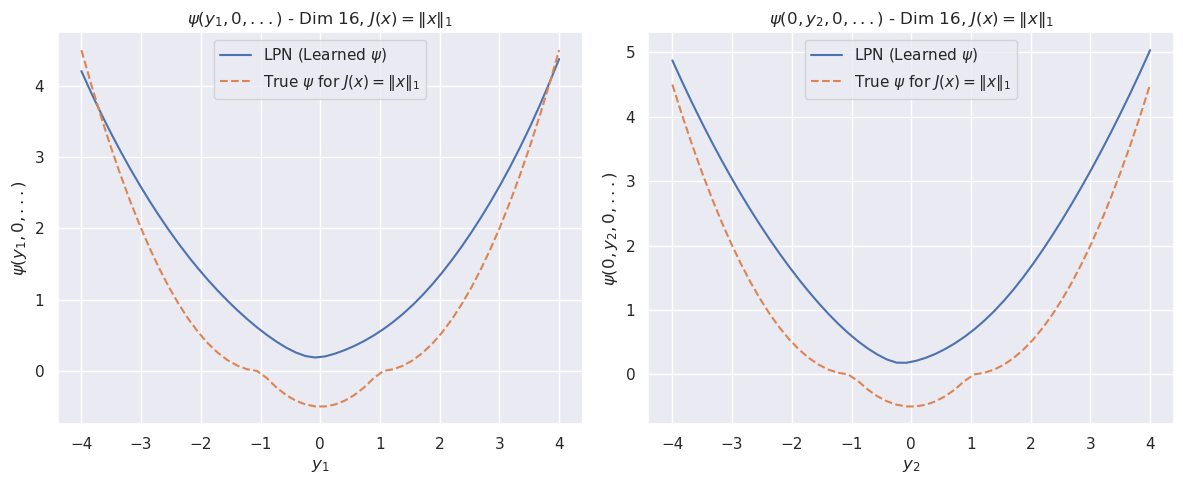

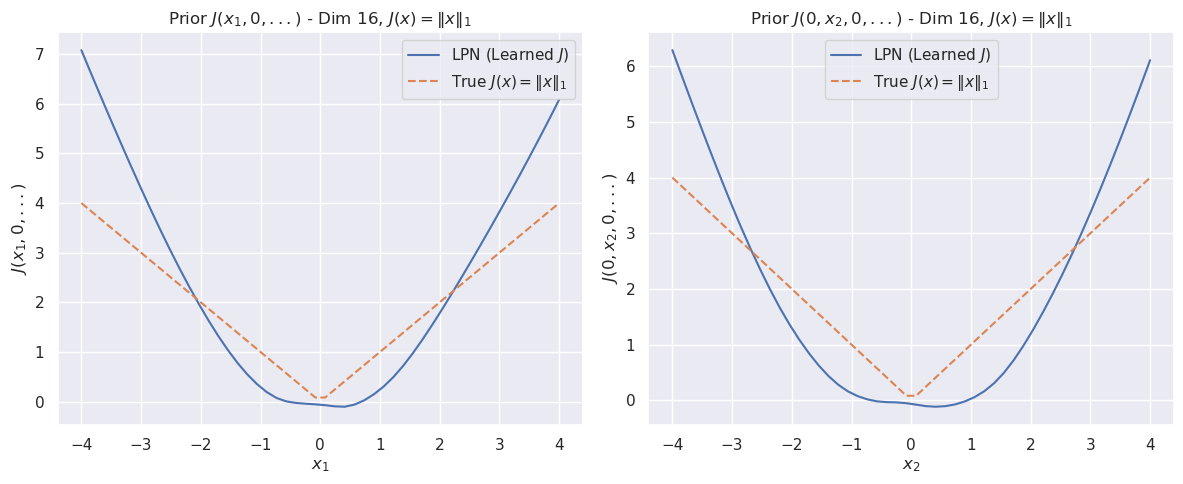

In [8]:
# L2 loss -- Plot
plot_all_quadratic_l1(lpn_model_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_quad_l2(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")



# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 # Use a smaller learning rate for the long phase
for i in range(iterations_exp_long):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")

Generated G samples: G_samples_tensor shape torch.Size([30000, 1])

--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 815.6610717773438
iteration 0 loss 517.9418334960938


iteration 500 loss 16.588958740234375


iteration 1000 loss 14.235674858093262


iteration 1500 loss 12.624043464660645


iteration 2000 loss 11.231857299804688


iteration 2500 loss 9.676424980163574


iteration 3000 loss 7.768983364105225


iteration 3500 loss 5.416667938232422


iteration 4000 loss 2.9208157062530518


iteration 4500 loss 1.5948834419250488


iteration 5000 loss 1.2168869972229004


iteration 5500 loss 0.9923584461212158


iteration 6000 loss 0.8366703391075134


iteration 6500 loss 0.7211942672729492


iteration 7000 loss 0.6320084929466248


iteration 7500 loss 0.5578980445861816


iteration 8000 loss 0.4927804172039032


iteration 8500 loss 0.433851957321167


iteration 9000 loss 0.38244304060935974


iteration 9500 loss 0.33913737535476685


iteration 10000 loss 0.2980567216873169


iteration 10500 loss 0.2536463141441345


iteration 11000 loss 0.20996825397014618


iteration 11500 loss 0.18443220853805542


iteration 12000 loss 0.1665973663330078


iteration 12500 loss 0.15363624691963196


iteration 13000 loss 0.1423010379076004


iteration 13500 loss 0.13429543375968933


iteration 14000 loss 0.12659284472465515


iteration 14500 loss 0.12041015177965164


iteration 15000 loss 0.11517329514026642


iteration 15500 loss 0.11082059890031815


iteration 16000 loss 0.10655247420072556


iteration 16500 loss 0.10324598848819733


iteration 17000 loss 0.09981520473957062


iteration 17500 loss 0.09676336497068405


iteration 18000 loss 0.09424835443496704


iteration 18500 loss 0.09158890694379807


iteration 19000 loss 0.08961186558008194


iteration 19500 loss 0.0876987874507904


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 0.08568287640810013


iteration 20500 loss 0.08547401428222656


iteration 21000 loss 0.08520950376987457


iteration 21500 loss 0.08487536013126373


iteration 22000 loss 0.0844554528594017


iteration 22500 loss 0.0839318335056305


iteration 23000 loss 0.0832853689789772


iteration 23500 loss 0.08249694108963013


iteration 24000 loss 0.08155034482479095


iteration 24500 loss 0.08043574541807175


iteration 25000 loss 0.0791732519865036


iteration 25500 loss 0.0779280737042427


iteration 26000 loss 0.07673659175634384


iteration 26500 loss 0.07564238458871841


iteration 27000 loss 0.07458405196666718


iteration 27500 loss 0.07360885292291641


iteration 28000 loss 0.0726860761642456


iteration 28500 loss 0.0718059167265892


iteration 29000 loss 0.07096997648477554


iteration 29500 loss 0.07017004489898682


iteration 30000 loss 0.06940188258886337


iteration 30500 loss 0.0686943382024765


iteration 31000 loss 0.06800521165132523


iteration 31500 loss 0.06736293435096741


iteration 32000 loss 0.06672463566064835


iteration 32500 loss 0.06612349301576614


iteration 33000 loss 0.06554009020328522


iteration 33500 loss 0.06499465554952621


iteration 34000 loss 0.06447437405586243


iteration 34500 loss 0.063969686627388


iteration 35000 loss 0.06349462270736694


iteration 35500 loss 0.06302391737699509


iteration 36000 loss 0.06258273869752884


iteration 36500 loss 0.062160417437553406


iteration 37000 loss 0.06175372749567032


iteration 37500 loss 0.06135575473308563


iteration 38000 loss 0.06098306551575661


iteration 38500 loss 0.06062772870063782


iteration 39000 loss 0.06028012931346893


iteration 39500 loss 0.0599646158516407


Learning rate decreased to 1.0000000000000002e-06 at iteration 40000
iteration 40000 loss 0.05964016914367676


iteration 40500 loss 0.05960280820727348


iteration 41000 loss 0.059557635337114334


iteration 41500 loss 0.059502389281988144


iteration 42000 loss 0.059436019510030746


iteration 42500 loss 0.05935771018266678


iteration 43000 loss 0.05926734209060669


iteration 43500 loss 0.05916548892855644


iteration 44000 loss 0.05905317887663841


iteration 44500 loss 0.058932047337293625


iteration 45000 loss 0.05880412831902504


iteration 45500 loss 0.05867325887084007


iteration 46000 loss 0.05854411795735359


iteration 46500 loss 0.05841759219765663


iteration 47000 loss 0.05829356238245964


iteration 47500 loss 0.058171965181827545


iteration 48000 loss 0.05805252492427826


iteration 48500 loss 0.057935021817684174


iteration 49000 loss 0.05781932175159454


iteration 49500 loss 0.05770525708794594


iteration 50000 loss 0.05759302154183388


iteration 50500 loss 0.057482413947582245


iteration 51000 loss 0.057373471558094025


iteration 51500 loss 0.05726619437336922


iteration 52000 loss 0.057160280644893646


iteration 52500 loss 0.057056229561567307


iteration 53000 loss 0.056953273713588715


iteration 53500 loss 0.05685172602534294


iteration 54000 loss 0.05675142630934715


iteration 54500 loss 0.05665220692753792


iteration 55000 loss 0.05655423179268837


iteration 55500 loss 0.056457504630088806


iteration 56000 loss 0.05636198818683624


iteration 56500 loss 0.056267768144607544


iteration 57000 loss 0.05617445707321167


iteration 57500 loss 0.05608248710632324


iteration 58000 loss 0.05599144101142883


iteration 58500 loss 0.05590139329433441


iteration 59000 loss 0.05581240728497505


iteration 59500 loss 0.055724918842315674


Learning rate decreased to 1.0000000000000002e-07 at iteration 60000
iteration 60000 loss 0.055638354271650314


iteration 60500 loss 0.05562940612435341


iteration 61000 loss 0.05561986565589905


iteration 61500 loss 0.055609844624996185


iteration 62000 loss 0.05559936910867691


iteration 62500 loss 0.055588606745004654


iteration 63000 loss 0.05557757988572121


iteration 63500 loss 0.05556638911366463


iteration 64000 loss 0.0555550791323185


iteration 64500 loss 0.05554371327161789


iteration 65000 loss 0.0555323101580143


iteration 65500 loss 0.05552089214324951


iteration 66000 loss 0.05550949648022652


iteration 66500 loss 0.0554981455206871


iteration 67000 loss 0.05548679083585739


iteration 67500 loss 0.055475473403930664


iteration 68000 loss 0.05546417832374573


iteration 68500 loss 0.05545291304588318


iteration 69000 loss 0.05544169992208481


iteration 69500 loss 0.055430494248867035


iteration 70000 loss 0.05541931465268135


iteration 70500 loss 0.05540819093585014


iteration 71000 loss 0.055397070944309235


iteration 71500 loss 0.05538596957921982


iteration 72000 loss 0.05537491291761398


iteration 72500 loss 0.055363867431879044


iteration 73000 loss 0.05535285174846649


iteration 73500 loss 0.05534185469150543


iteration 74000 loss 0.055330876260995865


iteration 74500 loss 0.055319931358098984


iteration 75000 loss 0.0553089939057827


iteration 75500 loss 0.0552980974316597


iteration 76000 loss 0.055287208408117294


iteration 76500 loss 0.05527632683515549


iteration 77000 loss 0.055265482515096664


iteration 77500 loss 0.05525466427206993


iteration 78000 loss 0.0552438385784626


iteration 78500 loss 0.055233050137758255


iteration 79000 loss 0.055222272872924805


iteration 79500 loss 0.05521150305867195


Learning rate decreased to 1.0000000000000004e-08 at iteration 80000
iteration 80000 loss 0.055200766772031784


iteration 80500 loss 0.055199749767780304


iteration 81000 loss 0.05519872531294823


iteration 81500 loss 0.05519770085811615


iteration 82000 loss 0.05519668757915497


iteration 82500 loss 0.05519566312432289


iteration 83000 loss 0.055194634944200516


iteration 83500 loss 0.05519362539052963


iteration 84000 loss 0.05519259348511696


iteration 84500 loss 0.05519156903028488


iteration 85000 loss 0.0551905632019043


iteration 85500 loss 0.05518953502178192


iteration 86000 loss 0.055188510566949844


iteration 86500 loss 0.05518750101327896


iteration 87000 loss 0.05518648773431778


iteration 87500 loss 0.055185467004776


iteration 88000 loss 0.055184442549943924


iteration 88500 loss 0.055183421820402145


iteration 89000 loss 0.05518241971731186


iteration 89500 loss 0.05518139526247978


iteration 90000 loss 0.0551803894340992


iteration 90500 loss 0.055179379880428314


iteration 91000 loss 0.055178359150886536


iteration 91500 loss 0.05517734959721565


iteration 92000 loss 0.05517633631825447


iteration 92500 loss 0.05517532303929329


iteration 93000 loss 0.055174313485622406


iteration 93500 loss 0.05517330393195152


iteration 94000 loss 0.055172279477119446


iteration 94500 loss 0.05517127737402916


iteration 95000 loss 0.05517026036977768


iteration 95500 loss 0.0551692470908165


iteration 96000 loss 0.05516824126243591


iteration 96500 loss 0.05516723915934563


iteration 97000 loss 0.055166229605674744


iteration 97500 loss 0.05516521632671356


iteration 98000 loss 0.05516420304775238


iteration 98500 loss 0.05516320839524269


iteration 99000 loss 0.05516219884157181


iteration 99500 loss 0.05516120418906212


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


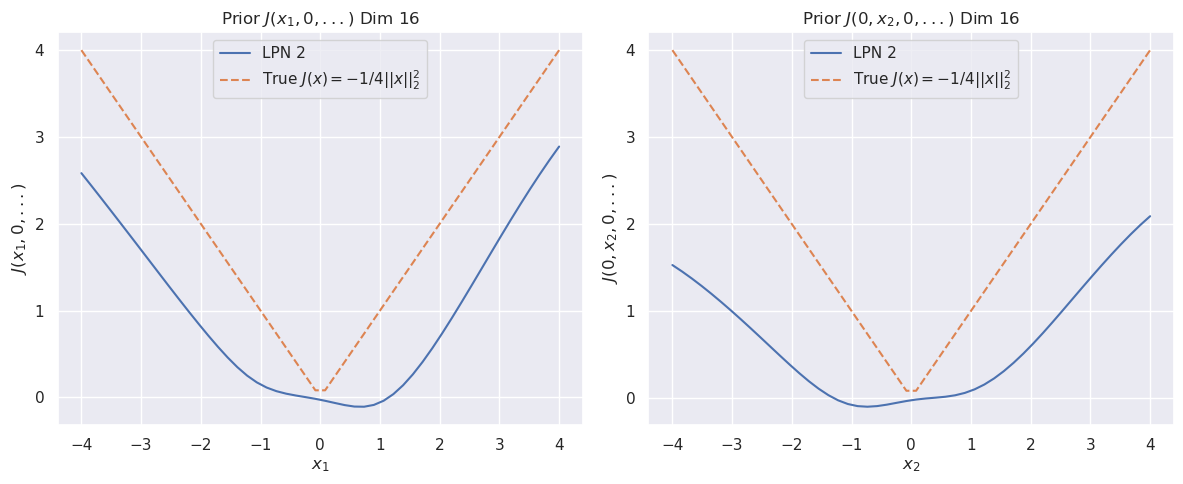

In [10]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_quadratic_l1(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_quadratic_l1(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)

L1 loss -- Train

In [11]:

print("--- Training LPN for J(x)=||x||_1 (Quadratic H) ---")
lpn_model_quad_l1 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_quad_l1 = torch.optim.Adam(lpn_model_quad_l1.parameters(), lr=1e-4)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_quad_l1, optimizer_quad_l1, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=1,gamma_loss=None)

for g in optimizer_quad_l1.param_groups:
    g["lr"] = 1e-4 
for i in range(iterations_exp_long):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_quad_l1.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_quad_l1, optimizer_quad_l1, y_j_exp_tensor,cvx_samples_exp_tensor,loss_type=1,gamma_loss=None)

torch.save(lpn_model_quad_l1.state_dict(), os.path.join(MODEL_DIR, "QuadraticH_L1prior_l1.pth"))

--- Training LPN for J(x)=||x||_1 (Quadratic H) ---
iteration 0 loss 24.227628707885742
iteration 0 loss 12.237192153930664


iteration 500 loss 2.528865098953247


iteration 1000 loss 2.329230785369873


iteration 1500 loss 2.162219285964966


iteration 2000 loss 1.9241893291473389


iteration 2500 loss 1.4493927955627441


iteration 3000 loss 0.8250564932823181


iteration 3500 loss 0.6972787380218506


iteration 4000 loss 0.6421093940734863


iteration 4500 loss 0.6090719103813171


iteration 5000 loss 0.5875099897384644


iteration 5500 loss 0.5725484490394592


iteration 6000 loss 0.5598631501197815


iteration 6500 loss 0.549532413482666


iteration 7000 loss 0.5411675572395325


iteration 7500 loss 0.5336030721664429


iteration 8000 loss 0.5265873670578003


iteration 8500 loss 0.5211285948753357


iteration 9000 loss 0.5153787732124329


iteration 9500 loss 0.5113372802734375


iteration 10000 loss 0.5071607828140259


iteration 10500 loss 0.5031816959381104


iteration 11000 loss 0.5001304149627686


iteration 11500 loss 0.49675285816192627


iteration 12000 loss 0.49368971586227417


iteration 12500 loss 0.490857869386673


iteration 13000 loss 0.4884987771511078


iteration 13500 loss 0.4859803318977356


iteration 14000 loss 0.4838431775569916


iteration 14500 loss 0.4817597568035126


iteration 15000 loss 0.47928497195243835


iteration 15500 loss 0.47800323367118835


iteration 16000 loss 0.4762245714664459


iteration 16500 loss 0.47382664680480957


iteration 17000 loss 0.4721175730228424


iteration 17500 loss 0.47127050161361694


iteration 18000 loss 0.46893027424812317


iteration 18500 loss 0.4674350321292877


iteration 19000 loss 0.4661165475845337


iteration 19500 loss 0.4648582637310028


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 0.4641401171684265


iteration 20500 loss 0.46291953325271606


iteration 21000 loss 0.46271324157714844


iteration 21500 loss 0.4625089168548584


iteration 22000 loss 0.46229004859924316


iteration 22500 loss 0.4621000587940216


iteration 23000 loss 0.461932897567749


iteration 23500 loss 0.461733877658844


iteration 24000 loss 0.4615403115749359


iteration 24500 loss 0.46134206652641296


iteration 25000 loss 0.4611680507659912


iteration 25500 loss 0.4610006511211395


iteration 26000 loss 0.460875004529953


iteration 26500 loss 0.4606785178184509


iteration 27000 loss 0.4604646563529968


iteration 27500 loss 0.46032699942588806


iteration 28000 loss 0.46016043424606323


iteration 28500 loss 0.45996785163879395


iteration 29000 loss 0.4598109722137451


iteration 29500 loss 0.45967569947242737


iteration 30000 loss 0.45946764945983887


iteration 30500 loss 0.45932480692863464


iteration 31000 loss 0.4591723680496216


iteration 31500 loss 0.45900747179985046


iteration 32000 loss 0.45886316895484924


iteration 32500 loss 0.4587516188621521


iteration 33000 loss 0.45858675241470337


iteration 33500 loss 0.458394855260849


iteration 34000 loss 0.45826661586761475


iteration 34500 loss 0.45814254879951477


iteration 35000 loss 0.4579930603504181


iteration 35500 loss 0.45780956745147705


iteration 36000 loss 0.4576846957206726


iteration 36500 loss 0.4575382471084595


iteration 37000 loss 0.4573923349380493


iteration 37500 loss 0.4572335481643677


iteration 38000 loss 0.4571109116077423


iteration 38500 loss 0.4569398760795593


iteration 39000 loss 0.45684391260147095


iteration 39500 loss 0.4566984474658966


Learning rate decreased to 1.0000000000000002e-06 at iteration 40000
iteration 40000 loss 0.4565601646900177


iteration 40500 loss 0.4564798176288605


iteration 41000 loss 0.4564610421657562


iteration 41500 loss 0.45644277334213257


iteration 42000 loss 0.4564211070537567


iteration 42500 loss 0.4564020335674286


iteration 43000 loss 0.4563843011856079


iteration 43500 loss 0.45636796951293945


iteration 44000 loss 0.456348180770874


iteration 44500 loss 0.4563349783420563


iteration 45000 loss 0.45631811022758484


iteration 45500 loss 0.456302285194397


iteration 46000 loss 0.4562838673591614


iteration 46500 loss 0.45626890659332275


iteration 47000 loss 0.4562540054321289


iteration 47500 loss 0.45623892545700073


iteration 48000 loss 0.456220805644989


iteration 48500 loss 0.45620980858802795


iteration 49000 loss 0.4561903774738312


iteration 49500 loss 0.45617544651031494


iteration 50000 loss 0.45616596937179565


iteration 50500 loss 0.456147164106369


iteration 51000 loss 0.45613232254981995


iteration 51500 loss 0.4561215341091156


iteration 52000 loss 0.4561035931110382


iteration 52500 loss 0.45608946681022644


iteration 53000 loss 0.45607465505599976


iteration 53500 loss 0.4560587406158447


iteration 54000 loss 0.4560445249080658


iteration 54500 loss 0.45602864027023315


iteration 55000 loss 0.456014484167099


iteration 55500 loss 0.4559990167617798


iteration 56000 loss 0.4559860825538635


iteration 56500 loss 0.4559701085090637


iteration 57000 loss 0.45595505833625793


iteration 57500 loss 0.4559422433376312


iteration 58000 loss 0.45592954754829407


iteration 58500 loss 0.45591309666633606


iteration 59000 loss 0.45589783787727356


iteration 59500 loss 0.45588260889053345


Learning rate decreased to 1.0000000000000002e-07 at iteration 60000
iteration 60000 loss 0.45586901903152466


iteration 60500 loss 0.45586326718330383


iteration 61000 loss 0.45586127042770386


iteration 61500 loss 0.4558594822883606


iteration 62000 loss 0.45585742592811584


iteration 62500 loss 0.45585691928863525


iteration 63000 loss 0.45585373044013977


iteration 63500 loss 0.4558519124984741


iteration 64000 loss 0.45585164427757263


iteration 64500 loss 0.455848753452301


iteration 65000 loss 0.4558461606502533


iteration 65500 loss 0.4558449387550354


iteration 66000 loss 0.45584335923194885


iteration 66500 loss 0.4558415412902832


iteration 67000 loss 0.4558395743370056


iteration 67500 loss 0.45583871006965637


iteration 68000 loss 0.4558366537094116


iteration 68500 loss 0.4558347761631012


iteration 69000 loss 0.4558334946632385


iteration 69500 loss 0.4558318555355072


iteration 70000 loss 0.45583027601242065


iteration 70500 loss 0.45582884550094604


iteration 71000 loss 0.4558272063732147


iteration 71500 loss 0.45582544803619385


iteration 72000 loss 0.45582398772239685


iteration 72500 loss 0.45582303404808044


iteration 73000 loss 0.45582106709480286


iteration 73500 loss 0.45581960678100586


iteration 74000 loss 0.4558177888393402


iteration 74500 loss 0.4558190107345581


iteration 75000 loss 0.4558153450489044


iteration 75500 loss 0.45581361651420593


iteration 76000 loss 0.4558122456073761


iteration 76500 loss 0.45581018924713135


iteration 77000 loss 0.45580869913101196


iteration 77500 loss 0.455807089805603


iteration 78000 loss 0.4558061957359314


iteration 78500 loss 0.45580416917800903


iteration 79000 loss 0.4558027982711792


iteration 79500 loss 0.455801397562027


Learning rate decreased to 1.0000000000000004e-08 at iteration 80000
iteration 80000 loss 0.45579975843429565


iteration 80500 loss 0.45579928159713745


iteration 81000 loss 0.45579928159713745


iteration 81500 loss 0.4557991921901703


iteration 82000 loss 0.4557991623878479


iteration 82500 loss 0.45579904317855835


iteration 83000 loss 0.45579883456230164


iteration 83500 loss 0.4557986259460449


iteration 84000 loss 0.455798476934433


iteration 84500 loss 0.4557981789112091


iteration 85000 loss 0.4557980000972748


iteration 85500 loss 0.45579779148101807


iteration 86000 loss 0.45579758286476135


iteration 86500 loss 0.455797404050827


iteration 87000 loss 0.4557971954345703


iteration 87500 loss 0.455797016620636


iteration 88000 loss 0.45579683780670166


iteration 88500 loss 0.45579665899276733


iteration 89000 loss 0.45579642057418823


iteration 89500 loss 0.4557962715625763


iteration 90000 loss 0.4557960629463196


iteration 90500 loss 0.45579591393470764


iteration 91000 loss 0.45579567551612854


iteration 91500 loss 0.4557955265045166


iteration 92000 loss 0.4557953476905823


iteration 92500 loss 0.45579516887664795


iteration 93000 loss 0.4557949900627136


iteration 93500 loss 0.4557948112487793


iteration 94000 loss 0.4557946026325226


iteration 94500 loss 0.4557943642139435


iteration 95000 loss 0.45579421520233154


iteration 95500 loss 0.45579400658607483


iteration 96000 loss 0.4557938277721405


iteration 96500 loss 0.4557936191558838


iteration 97000 loss 0.45579344034194946


iteration 97500 loss 0.4557932913303375


iteration 98000 loss 0.4557931125164032


iteration 98500 loss 0.4557928740978241


iteration 99000 loss 0.4557928442955017


iteration 99500 loss 0.455792635679245


L1 loss -- Plot


--- Plotting Cross Sections for Quadratic H, L1 Prior (Dim=16) ---
loss -3.7354559898376465


loss -66.82245635986328


loss -106.66447448730469


loss -139.44873046875


loss -166.18563842773438


loss -188.1255340576172


loss -206.21493530273438


loss -221.03616333007812


loss -233.01632690429688


loss -242.53126525878906


loss -249.94911193847656


loss -255.60289001464844


loss -259.7560729980469


loss -262.6452331542969


loss -264.514892578125


loss -265.6133728027344


loss -266.181640625


loss -266.4312744140625


loss -266.52020263671875


loss -266.5444030761719


loss -266.5491027832031


loss -266.5496520996094


loss -266.5497131347656


loss -266.5497131347656


loss -266.5497131347656


loss -266.5497131347656


loss -266.5497131347656


loss -266.5497131347656


loss -266.5497131347656


loss -266.5497131347656


loss -266.5497131347656


loss -266.5497131347656


loss -266.5497131347656


loss -266.5497131347656


loss -266.5497131347656


loss -266.5497131347656


loss -266.5496826171875


loss -266.5496826171875


loss -266.5497131347656


loss -266.5497131347656


final mse:  1.2144573124928115e-09
max, min: 6.8333225 -6.5729055
loss -3.7354559898376465


loss -69.378662109375


loss -109.80612182617188


loss -143.7202606201172


loss -172.30618286132812


loss -196.1181640625


loss -215.4666748046875


loss -230.64776611328125


loss -242.24752807617188


loss -251.015869140625


loss -257.6614990234375


loss -262.68524169921875


loss -266.4266662597656


loss -269.13079833984375


loss -270.98406982421875


loss -272.1536865234375


loss -272.8128662109375


loss -273.13372802734375


loss -273.2635803222656


loss -273.3051452636719


loss -273.3150634765625


loss -273.3166809082031


loss -273.3168640136719


loss -273.3168640136719


loss -273.3168640136719


loss -273.3168640136719


loss -273.3168640136719


loss -273.3168640136719


loss -273.3168640136719


loss -273.3168640136719


loss -273.31683349609375


loss -273.31683349609375


loss -273.3168640136719


loss -273.3168640136719


loss -273.3168640136719


loss -273.3168640136719


loss -273.3168640136719


loss -273.31683349609375


loss -273.31683349609375


loss -273.3168640136719


final mse:  8.961067998747296e-10
max, min: 6.607749 -6.9895196


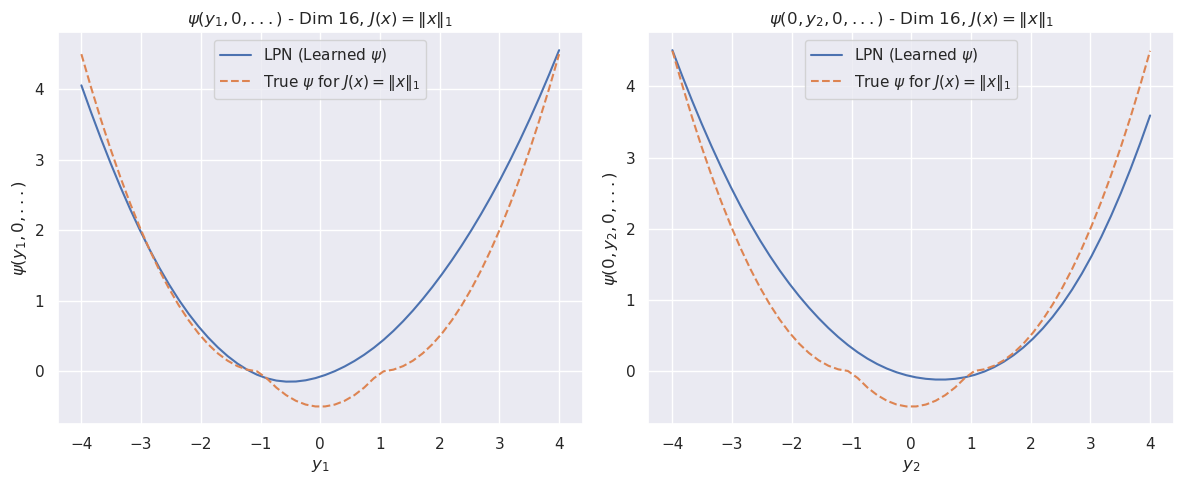

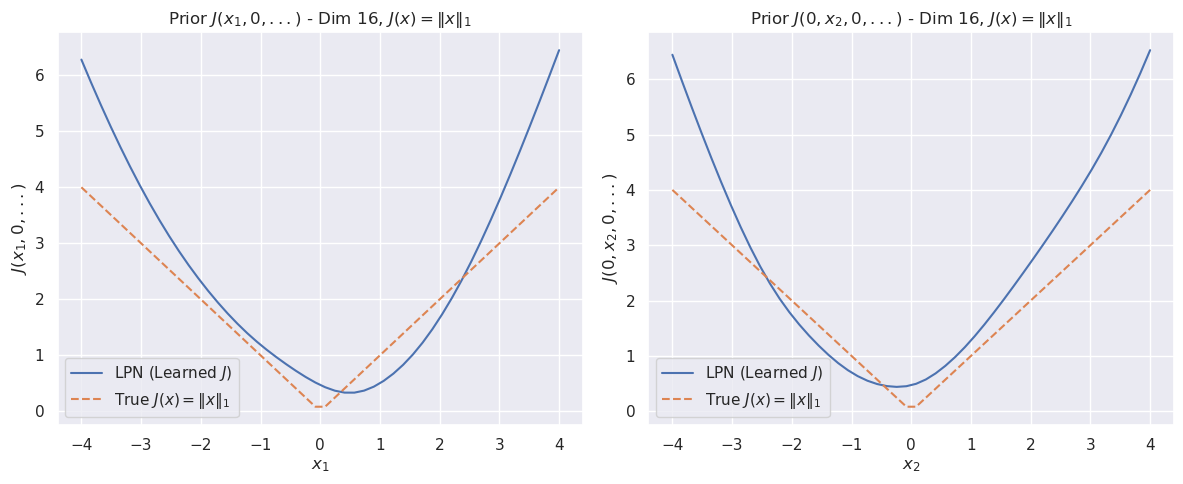

In [12]:
# L1 loss -- Plot
plot_all_quadratic_l1(lpn_model_quad_l1, a_exp, spacing, INVERT_MODE, dim_exp)


In [13]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_quad_l1.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_quad_l1(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")



# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 # Use a smaller learning rate for the long phase
for i in range(iterations_exp_long):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")

Generated G samples: G_samples_tensor shape torch.Size([30000, 1])

--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 673.2371215820312
iteration 0 loss 352.5652770996094


iteration 500 loss 10.200592041015625


iteration 1000 loss 8.788565635681152


iteration 1500 loss 8.012038230895996


iteration 2000 loss 7.396777153015137


iteration 2500 loss 6.7193779945373535


iteration 3000 loss 5.9071760177612305


iteration 3500 loss 4.919990062713623


iteration 4000 loss 3.711352586746216


iteration 4500 loss 2.3293209075927734


iteration 5000 loss 1.3262107372283936


iteration 5500 loss 0.9876176118850708


iteration 6000 loss 0.8107592463493347


iteration 6500 loss 0.6851034164428711


iteration 7000 loss 0.5915391445159912


iteration 7500 loss 0.5194832682609558


iteration 8000 loss 0.45845022797584534


iteration 8500 loss 0.40587612986564636


iteration 9000 loss 0.36099159717559814


iteration 9500 loss 0.3246828019618988


iteration 10000 loss 0.2943057715892792


iteration 10500 loss 0.26900649070739746


iteration 11000 loss 0.2504095435142517


iteration 11500 loss 0.23562505841255188


iteration 12000 loss 0.22470322251319885


iteration 12500 loss 0.21447256207466125


iteration 13000 loss 0.2063656896352768


iteration 13500 loss 0.19836999475955963


iteration 14000 loss 0.1918601244688034


iteration 14500 loss 0.18605665862560272


iteration 15000 loss 0.1811770498752594


iteration 15500 loss 0.1769265979528427


iteration 16000 loss 0.17344316840171814


iteration 16500 loss 0.17010001838207245


iteration 17000 loss 0.16760165989398956


iteration 17500 loss 0.16469447314739227


iteration 18000 loss 0.16237777471542358


iteration 18500 loss 0.16002321243286133


iteration 19000 loss 0.15804536640644073


iteration 19500 loss 0.15602393448352814


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 0.15442727506160736


iteration 20500 loss 0.1542198210954666


iteration 21000 loss 0.1539657562971115


iteration 21500 loss 0.153643399477005


iteration 22000 loss 0.15323613584041595


iteration 22500 loss 0.1527244746685028


iteration 23000 loss 0.15208746492862701


iteration 23500 loss 0.151302769780159


iteration 24000 loss 0.15034978091716766


iteration 24500 loss 0.14921490848064423


iteration 25000 loss 0.14791272580623627


iteration 25500 loss 0.14652936160564423


iteration 26000 loss 0.14521433413028717


iteration 26500 loss 0.14397555589675903


iteration 27000 loss 0.1428045630455017


iteration 27500 loss 0.1416996568441391


iteration 28000 loss 0.1406445950269699


iteration 28500 loss 0.1396375298500061


iteration 29000 loss 0.13868586719036102


iteration 29500 loss 0.13778401911258698


iteration 30000 loss 0.13692937791347504


iteration 30500 loss 0.1361209750175476


iteration 31000 loss 0.13535605370998383


iteration 31500 loss 0.13463038206100464


iteration 32000 loss 0.1339375078678131


iteration 32500 loss 0.13327808678150177


iteration 33000 loss 0.13265566527843475


iteration 33500 loss 0.13206037878990173


iteration 34000 loss 0.13149960339069366


iteration 34500 loss 0.1309579759836197


iteration 35000 loss 0.13044263422489166


iteration 35500 loss 0.1299562007188797


iteration 36000 loss 0.1294998675584793


iteration 36500 loss 0.129050150513649


iteration 37000 loss 0.12861886620521545


iteration 37500 loss 0.12820228934288025


iteration 38000 loss 0.12780506908893585


iteration 38500 loss 0.12742389738559723


iteration 39000 loss 0.12705537676811218


iteration 39500 loss 0.1267014443874359


Learning rate decreased to 1.0000000000000002e-06 at iteration 40000
iteration 40000 loss 0.12635928392410278


iteration 40500 loss 0.12632343173027039


iteration 41000 loss 0.12627926468849182


iteration 41500 loss 0.12622545659542084


iteration 42000 loss 0.12616121768951416


iteration 42500 loss 0.12608595192432404


iteration 43000 loss 0.12599964439868927


iteration 43500 loss 0.12590308487415314


iteration 44000 loss 0.12579746544361115


iteration 44500 loss 0.12568436563014984


iteration 45000 loss 0.12556560337543488


iteration 45500 loss 0.1254437118768692


iteration 46000 loss 0.1253211796283722


iteration 46500 loss 0.12520091235637665


iteration 47000 loss 0.12508255243301392


iteration 47500 loss 0.12496598809957504


iteration 48000 loss 0.12485110759735107


iteration 48500 loss 0.1247376948595047


iteration 49000 loss 0.12462572008371353


iteration 49500 loss 0.1245151236653328


iteration 50000 loss 0.12440597265958786


iteration 50500 loss 0.12429793179035187


iteration 51000 loss 0.12419094145298004


iteration 51500 loss 0.12408502399921417


iteration 52000 loss 0.12398006021976471


iteration 52500 loss 0.12387628108263016


iteration 53000 loss 0.12377341091632843


iteration 53500 loss 0.12367137521505356


iteration 54000 loss 0.12357056885957718


iteration 54500 loss 0.12347039580345154


iteration 55000 loss 0.12337101250886917


iteration 55500 loss 0.12327251583337784


iteration 56000 loss 0.12317490577697754


iteration 56500 loss 0.12307778000831604


iteration 57000 loss 0.12298154085874557


iteration 57500 loss 0.12288583070039749


iteration 58000 loss 0.1227910965681076


iteration 58500 loss 0.1226968914270401


iteration 59000 loss 0.12260356545448303


iteration 59500 loss 0.12251074612140656


Learning rate decreased to 1.0000000000000002e-07 at iteration 60000
iteration 60000 loss 0.12241842597723007


iteration 60500 loss 0.12240903824567795


iteration 61000 loss 0.12239920347929001


iteration 61500 loss 0.12238911539316177


iteration 62000 loss 0.12237879633903503


iteration 62500 loss 0.12236824631690979


iteration 63000 loss 0.12235762178897858


iteration 63500 loss 0.122346892952919


iteration 64000 loss 0.12233611941337585


iteration 64500 loss 0.12232531607151031


iteration 65000 loss 0.12231452018022537


iteration 65500 loss 0.12230371683835983


iteration 66000 loss 0.12229293584823608


iteration 66500 loss 0.12228217720985413


iteration 67000 loss 0.12227143347263336


iteration 67500 loss 0.12226072698831558


iteration 68000 loss 0.122250035405159


iteration 68500 loss 0.12223934382200241


iteration 69000 loss 0.12222868204116821


iteration 69500 loss 0.1222180426120758


iteration 70000 loss 0.12220742553472519


iteration 70500 loss 0.12219683080911636


iteration 71000 loss 0.12218625098466873


iteration 71500 loss 0.1221756711602211


iteration 72000 loss 0.12216511368751526


iteration 72500 loss 0.1221545934677124


iteration 73000 loss 0.12214405834674835


iteration 73500 loss 0.12213356792926788


iteration 74000 loss 0.12212307006120682


iteration 74500 loss 0.12211260944604874


iteration 75000 loss 0.12210215628147125


iteration 75500 loss 0.12209171801805496


iteration 76000 loss 0.12208127230405807


iteration 76500 loss 0.12207083404064178


iteration 77000 loss 0.12206040322780609


iteration 77500 loss 0.122049979865551


iteration 78000 loss 0.12203961610794067


iteration 78500 loss 0.12202922999858856


iteration 79000 loss 0.12201886624097824


iteration 79500 loss 0.12200850248336792


Learning rate decreased to 1.0000000000000004e-08 at iteration 80000
iteration 80000 loss 0.12199817597866058


iteration 80500 loss 0.12199714779853821


iteration 81000 loss 0.12199611216783524


iteration 81500 loss 0.12199506908655167


iteration 82000 loss 0.12199404090642929


iteration 82500 loss 0.12199299782514572


iteration 83000 loss 0.12199195474386215


iteration 83500 loss 0.12199091911315918


iteration 84000 loss 0.12198985368013382


iteration 84500 loss 0.12198885530233383


iteration 85000 loss 0.12198780477046967


iteration 85500 loss 0.1219867616891861


iteration 86000 loss 0.12198573350906372


iteration 86500 loss 0.12198468297719955


iteration 87000 loss 0.12198365479707718


iteration 87500 loss 0.1219826191663742


iteration 88000 loss 0.12198159098625183


iteration 88500 loss 0.12198054790496826


iteration 89000 loss 0.12197951227426529


iteration 89500 loss 0.12197849154472351


iteration 90000 loss 0.12197745591402054


iteration 90500 loss 0.12197642028331757


iteration 91000 loss 0.12197539210319519


iteration 91500 loss 0.12197434902191162


iteration 92000 loss 0.12197332829236984


iteration 92500 loss 0.12197229266166687


iteration 93000 loss 0.1219712495803833


iteration 93500 loss 0.12197024375200272


iteration 94000 loss 0.12196920812129974


iteration 94500 loss 0.12196817994117737


iteration 95000 loss 0.12196716666221619


iteration 95500 loss 0.12196611613035202


iteration 96000 loss 0.12196507304906845


iteration 96500 loss 0.12196404486894608


iteration 97000 loss 0.12196303904056549


iteration 97500 loss 0.12196199595928192


iteration 98000 loss 0.12196099013090134


iteration 98500 loss 0.12195993959903717


iteration 99000 loss 0.1219589114189148


iteration 99500 loss 0.12195789813995361


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


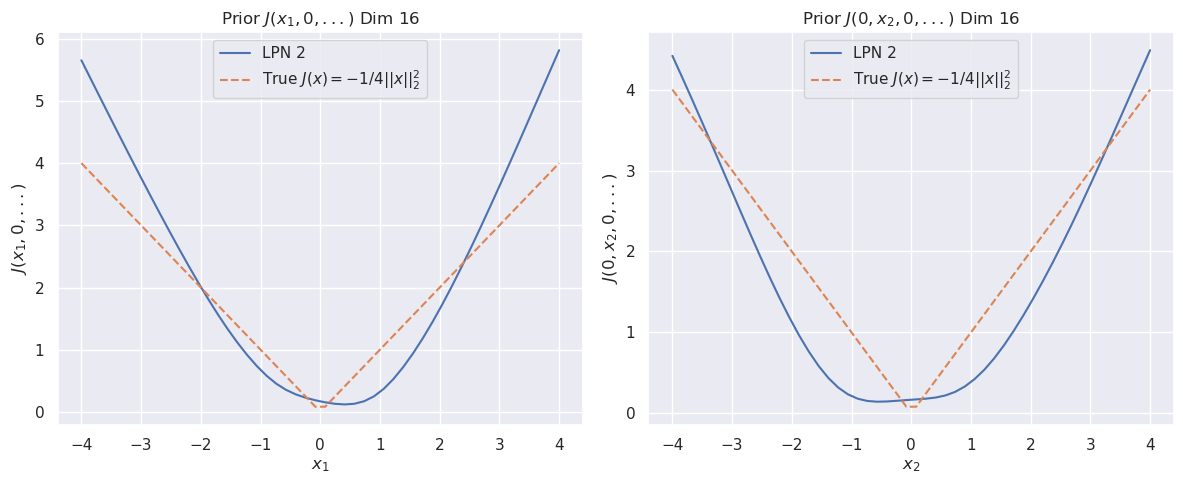

In [14]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_quadratic_l1(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_quadratic_l1(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)

Proximal matching loss.
We perform proximal matching loss with a decreasing sequence of gamma parameters.

gamma = 20 -- Train

In [15]:
# lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
# optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

# loss_type = 0
# gamma_loss = 20

# # set learning rate
# for g in optimizer.param_groups:
#     g["lr"] = 1e-4

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 20 -- Plot

In [16]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

gamma = 12.5 -- Train

In [17]:
# gamma_loss = 12.5

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(6000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 12.5 -- Plot

In [18]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

gamma = 10 -- Train

In [19]:
# gamma_loss = 10

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(10000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 10 -- Plot

In [20]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)